# Image colorization using CNN with a special loss


## Libraries and hardware setup


In [1]:
!pip install kornia

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 5.8 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import pickle
import kornia

from statistics import mean
from skimage.color import rgb2lab

import time

from matplotlib.colors import LogNorm

from torch.utils.data import DataLoader, random_split
from torchvision import transforms, models
import torch.utils.data as data_utils
import torchvision


In [3]:
torch.cuda.is_available()

False

In [4]:
if torch.cuda.is_available():
  device = torch.device("cuda")

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Training and validation set



### Import dataset

In [6]:
ab1 = np.load('/content/gdrive/MyDrive/Vision/Progetto/PROGETTO_FINALE/ab1.npy', encoding='bytes')
ab1_small = torch.tensor(ab1[:3000, :, :, :], dtype=torch.float16) - 128

del ab1

ab1_small = torch.permute(ab1_small, [0, 3, 1, 2])
print(ab1_small.shape)

torch.Size([3000, 2, 224, 224])


In [7]:
l = np.load('/content/gdrive/MyDrive/Vision/Progetto/PROGETTO_FINALE/gray_scale.npy', encoding='bytes')
l_tensor = torch.tensor(l[:3000, :, :], dtype=torch.float32)

del l

l_tensor = l_tensor / 255
print(l_tensor.shape)

torch.Size([3000, 224, 224])


In [8]:
def LAB_to_RGB(l_tensor, ab_tensor):
  tensor = torch.cat([torch.unsqueeze(l_tensor,0), ab_tensor], dim = 0)
  tensor = kornia.color.lab_to_rgb(tensor)
  return tensor

torch.Size([2, 224, 224])
torch.Size([224, 224])


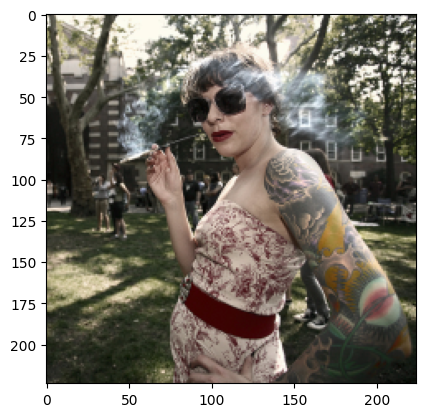

In [9]:
for x in range(1):
  img_ab = ab1_small[x]
  img_l = l_tensor[x] * 100

  print(img_ab.shape)
  print(img_l.shape)


  img = LAB_to_RGB(img_l, img_ab)
  plt.imshow(torch.permute(img, [1,2,0]))
  plt.show()

In [10]:
dataset_ab = ab1_small
dataset_l = torch.cat([l_tensor.unsqueeze(0)] * 3, dim=0)
dataset_l = torch.permute(dataset_l, [1,0,2,3])

print(dataset_ab.shape)
print(dataset_l.shape)

del ab1_small
del l_tensor

torch.Size([3000, 2, 224, 224])
torch.Size([3000, 3, 224, 224])


### Distribution of (a,b)

xedges: [-110. -100.  -90.  -80.  -70.  -60.  -50.  -40.  -30.  -20.  -10.    0.
   10.   20.   30.   40.   50.   60.   70.   80.   90.  100.  110.] 

Number of images: 3000 

Number of entries in the histogram: 150528000.0 



<ipython-input-11-afc4190668fa>:22: RuntimeWarning: divide by zero encountered in log
  hist_log = np.log((hist/np.sum(hist)))


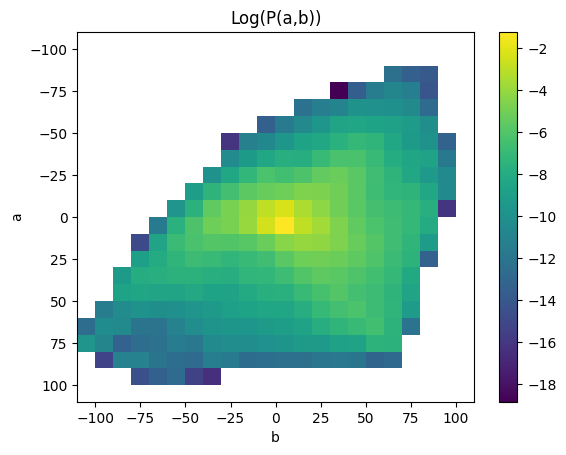

In [11]:
x = dataset_ab[:,0,:,:]
x = torch.squeeze(x)

a = dataset_ab[:,0,:,:].reshape(1,-1)
a = torch.squeeze(a).numpy()

b = dataset_ab[:,1,:,:].reshape(1,-1)
b = torch.squeeze(b).numpy()

x_min, x_max = -110, 110
y_min, y_max = -110, 110

hist, xedges, yedges = np.histogram2d(a, b, bins=22, range=[[x_min, x_max], [y_min, y_max]])

print('xedges:', xedges, '\n')

print('Number of images:', len(x), '\n')
print('Number of entries in the histogram:', np.sum(hist), '\n')


# empirical probability --> value / normalization
hist_log = np.log((hist/np.sum(hist)))

# Plot the histogram in logarithmic scale
plt.imshow(np.flip(hist_log, 0), interpolation='nearest', extent=[x_min, x_max, y_max, y_min], origin='lower', aspect='auto')
plt.colorbar()
plt.xlabel('b')
plt.ylabel('a')
plt.title('Log(P(a,b))')
plt.show()

We now want to map each upperleft corner of a nonzero bin to its bin number

In [12]:
Q = np.sum(np.isfinite(hist_log))
print("With our dataset we get Q = ", Q)

With our dataset we get Q =  259


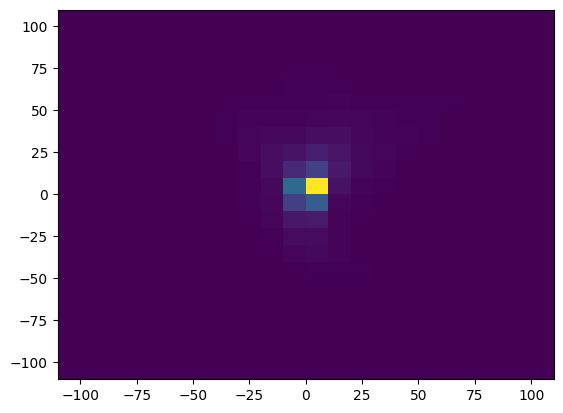

In [13]:
hist_obj = plt.hist2d(a, b, bins = 22, range=[[x_min, x_max], [y_min, y_max]])

In [14]:
# Keep track of where the grid points are
positions = []
indeces = []

index = 0

# check all the position in the histogram and whenever it finds a value bigger than zero it saves the position in an dictionary

for i in range(len(hist_obj[1][:-1])):
  for j in range(len(hist_obj[2][:-1])):
    if hist_obj[0][i, j] > 0:
      positions.append((i,j))
      indeces.append(index)
      index += 1

dictionary = dict(zip(positions, indeces))
dictionary_inverse = dict(zip(indeces, positions)) # dictionary_inverse[132] --> (5, 7)

In [15]:
dictionary.keys()

dict_keys([(2, 17), (2, 18), (2, 19), (3, 14), (3, 15), (3, 16), (3, 17), (3, 18), (3, 19), (4, 12), (4, 13), (4, 14), (4, 15), (4, 16), (4, 17), (4, 18), (4, 19), (5, 10), (5, 11), (5, 12), (5, 13), (5, 14), (5, 15), (5, 16), (5, 17), (5, 18), (5, 19), (6, 8), (6, 9), (6, 10), (6, 11), (6, 12), (6, 13), (6, 14), (6, 15), (6, 16), (6, 17), (6, 18), (6, 19), (6, 20), (7, 8), (7, 9), (7, 10), (7, 11), (7, 12), (7, 13), (7, 14), (7, 15), (7, 16), (7, 17), (7, 18), (7, 19), (7, 20), (8, 7), (8, 8), (8, 9), (8, 10), (8, 11), (8, 12), (8, 13), (8, 14), (8, 15), (8, 16), (8, 17), (8, 18), (8, 19), (8, 20), (9, 6), (9, 7), (9, 8), (9, 9), (9, 10), (9, 11), (9, 12), (9, 13), (9, 14), (9, 15), (9, 16), (9, 17), (9, 18), (9, 19), (9, 20), (10, 5), (10, 6), (10, 7), (10, 8), (10, 9), (10, 10), (10, 11), (10, 12), (10, 13), (10, 14), (10, 15), (10, 16), (10, 17), (10, 18), (10, 19), (10, 20), (11, 4), (11, 5), (11, 6), (11, 7), (11, 8), (11, 9), (11, 10), (11, 11), (11, 12), (11, 13), (11, 14), (11

### Store new dataset in the new form

In [ ]:
length = 3000

output_tensor = torch.zeros(length, 1, 224, 224)

for image_number in range(length):
  if image_number % 100 == 0:
    print("Image_nUmber : ", image_number)
  Z_image = np.zeros([1, 224, 224])
  image = dataset_ab[image_number, :, :, :]

  channel_a = torch.Tensor.int((image[0, : , :] + 110) // 10)
  channel_b = torch.Tensor.int((image[1, : , :] + 110) // 10)

  entries = [dictionary[index] for index in zip(torch.reshape(channel_a, [-1]).tolist(), torch.reshape(channel_b, [-1]).tolist())]
  entries = torch.reshape(torch.Tensor(entries), [1, 224, 224])

  output_tensor[image_number, :, :, :] = torch.tensor(entries)

Image_nUmber :  0


<ipython-input-19-d36d7d54cbbb>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output_tensor[image_number, :, :, :] = torch.tensor(entries)


Image_nUmber :  100
Image_nUmber :  200
Image_nUmber :  300
Image_nUmber :  400
Image_nUmber :  500
Image_nUmber :  600
Image_nUmber :  700
Image_nUmber :  800
Image_nUmber :  900
Image_nUmber :  1000
Image_nUmber :  1100
Image_nUmber :  1200
Image_nUmber :  1300
Image_nUmber :  1400
Image_nUmber :  1500
Image_nUmber :  1600
Image_nUmber :  1700
Image_nUmber :  1800
Image_nUmber :  1900
Image_nUmber :  2000
Image_nUmber :  2100
Image_nUmber :  2200
Image_nUmber :  2300
Image_nUmber :  2400
Image_nUmber :  2500
Image_nUmber :  2600
Image_nUmber :  2700
Image_nUmber :  2800
Image_nUmber :  2900


In [ ]:
dataset_l.shape

torch.Size([3000, 3, 224, 224])

In [ ]:
dataset_l  = torch.cat([torch.unsqueeze(tens, 0) for tens in dataset_l])
dataset_Z = torch.Tensor.int(output_tensor)

print(dataset_l.shape)
print(dataset_Z.shape)


#Set up new dataset
N_images = 2500
train = data_utils.TensorDataset(dataset_l[: N_images], dataset_Z[: N_images])
test = data_utils.TensorDataset(dataset_l[N_images:], dataset_Z[N_images: ])

torch.Size([3000, 3, 224, 224])
torch.Size([3000, 1, 224, 224])


In [ ]:
pickle.dump(train, open("DF_GRANDE_3000.pkl", "wb"))

pickle.dump(test, open("DF_GRANDE_3000_test.pkl", "wb"))

In [ ]:
!cp DF_GRANDE_3000.pkl /content/gdrive/MyDrive/Vision/Progetto/PROGETTO_FINALE

In [ ]:
!cp DF_GRANDE_3000_test.pkl /content/gdrive/MyDrive/Vision/Progetto/PROGETTO_FINALE

### Load new dataset

In [16]:
objects = []
with (open("/content/gdrive/MyDrive/Vision/Progetto/PROGETTO_FINALE/DF_GRANDE_3000.pkl", "rb")) as openfile:
    while True:
        try:
            objects.append(pickle.load(openfile))
        except EOFError:
            break

with (open("/content/gdrive/MyDrive/Vision/Progetto/PROGETTO_FINALE/DF_GRANDE_3000_test.pkl", "rb")) as openfile:
    while True:
        try:
            objects.append(pickle.load(openfile))
        except EOFError:
            break

In [17]:
train = objects[0]
test = objects[1]

### Computation of $\vec{w}$

In [18]:
#Store indeces as tensor

position_tensor = torch.zeros([len(hist_obj[1][:-1]), len(hist_obj[2][:-1])] )
for position, index in zip(positions, indeces):
  position_tensor[position[0], position[1]] = index

position_tensor = torch.Tensor.int(position_tensor)

In [19]:
l = 0.5                                  # lambda
p = np.ndarray.flatten(hist_obj[0])
p = p[p > 0.]                            # p is a 1D array with the non-zero probabilities
p = p / np.sum(p)

Q = len(p)

w = 1 / ((1-l)*p + l/Q)
w = w / np.dot(w , p)

In [20]:
#Plot w to check if it's ok
zeros = np.zeros((22, 22))
for i in range(len(w)):
  zeros[dictionary_inverse[i]] = w[i]

Text(0.5, 1.0, 'w values')

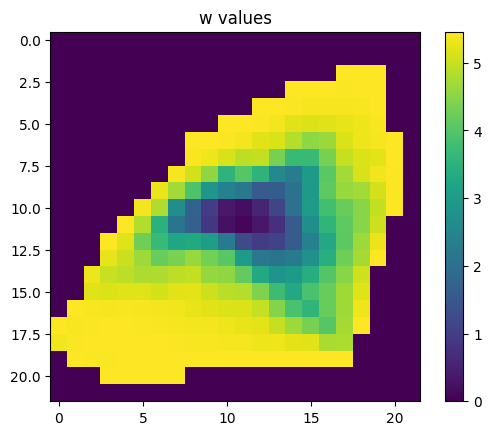

In [21]:
im = plt.imshow(zeros)
plt.colorbar(im)
plt.title("w values")

## Training with special loss
We train the network, using the following loss:

$L_{cl} = - \sum_{h,w, q} v(Z_{hw}) Z_{h,w,q}\log(\hat{Z}_{hwq})$,  $v(Z_{hw}) = w_{q^*}$, where $q^*$ is the index of the corresponding bin. We encode the ground truth $Z_{h,w,q}$ using one-hot-encoding.

*Reminder: Z has the shape of (1, h, w, q)*.

In [22]:
#Data loader
batch_size = 10
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=True)

In [23]:
w = torch.tensor(w)
w = w.clone().detach()

In [24]:
class network_model_newLoss(nn.Module):
  def __init__(self):
    super(network_model_newLoss, self).__init__()

    resnet = models.resnet18(weights = "IMAGENET1K_V1")                   # import all resnet18 already trained
    self.resnet_base = nn.Sequential(*list(resnet.children())[0:6])       # take the first 6 layers of resnet, which end with 128 channels

    for param in self.resnet_base.parameters():                           # freeze the parameter of resnet_base
      param.requires_grad = False


    self.cnn_next = nn.Sequential(
      nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.Upsample(scale_factor = 2),
      nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Conv2d(64, Q, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(Q),
      nn.ReLU(),
    )

  def forward(self, input):
    y = self.resnet_base(input)                                           # first go through resnet
    z = self.cnn_next(y)                                                  # then go through our layers
    upsample = torch.nn.Upsample(size = [224, 224])
    return upsample(z)

In [ ]:
from torch.optim.lr_scheduler import ExponentialLR

network = network_model_newLoss()                                               # CNN
loss = nn.MSELoss()                                                             # We begin with a simple MSE loss function
optim = torch.optim.Adam(network.parameters(), lr=1e-3, weight_decay=0.0)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 106MB/s]


In [ ]:
losses_train = []
losses_val = []

epochs = 100
patience = 10                                                                   # how many epochs of non decreasing validation we accept
min_val = 0                                                                     # minimum validation loss (initialized to a meaningless value - we will update it at the first epoch)

PATH = "model_trained_horizontalflip_newloss.pt"

w = torch.tensor(w).to(device)

v_prova = torch.ones([batch_size, 64, 64])


transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
])


with torch.autograd.set_detect_anomaly(False):
  for epoch in range(epochs):
    print("Epoch ", epoch)
    network.train()
    i = 0
    ls = []
    for features, labels in train_loader:
      transformed_batch = torch.stack([transform(img) for img in features])
      features = transformed_batch
      features = features.to(device)
      labels = labels.to(device)
      network = network.to(device)



      now = time.time()
      predictions = network(features)
      then = time.time()
      v = w[labels]

      zeros = torch.zeros(batch_size, Q, 224, 224, dtype = torch.float64).to(device)
      one_hot = zeros.scatter(dim = 1, index = labels.type(torch.int64), src = v)

      L = loss(predictions, one_hot.type(torch.float32))
      ls.append(L.item())

      optim.zero_grad()
      L.backward()
      optim.step()

      if i%50 == 0:
        print("Loss at iteration ",  i , " is ", L.item())
      i += 1
    losses_train.append(mean(ls))


#########################################################################################

    #Validation loss
    network.eval()
    with torch.no_grad():
      val_batches = []
      for features, labels in test_loader:
        features = features.to(device)
        labels = labels.to(device)
        network = network.to(device)

        prediction_val = network(features)

        v = w[labels]
        zeros = torch.zeros(batch_size, Q, 224, 224, dtype = torch.float64).to(device)
        one_hot = zeros.scatter(dim = 1, index = labels.type(torch.int64), src = v)

        val_loss = loss(prediction_val, one_hot.type(torch.float32))
        val_batches.append(val_loss.item())
      print("At epoch ", epoch, " validation loss ", mean(val_batches))
      losses_val.append(mean(val_batches))

    #Early stopping
    if epoch == 1:
      min_val = mean(val_batches)

    if mean(val_batches) < min_val:
      min_val = mean(val_batches)
      torch.save({
            'epoch': epoch,
            'model_state_dict': network.state_dict(),
            'optimizer_state_dict': optim.state_dict(),
            'loss': min_val,
            }, PATH)

    #Early stopping: break if no new minimum was reached in the last *patience* epochs

    if epoch >= patience:
        condition = 0
        for index in range(patience):
          if losses_val[-(index + 1)] > min_val:
            condition += 1
        if condition == patience:
          print("Early stopping!")
          break

<ipython-input-42-433646bc094a>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  w = torch.tensor(w).to(device)


Epoch  0
Loss at iteration  0  is  0.5047177076339722
Loss at iteration  50  is  0.01491475012153387
Loss at iteration  100  is  0.0074035669676959515
Loss at iteration  150  is  0.011727342382073402
Loss at iteration  200  is  0.009274848736822605
At epoch  0  validation loss  0.011196331270039082
Epoch  1
Loss at iteration  0  is  0.013051806949079037
Loss at iteration  50  is  0.008331391960382462
Loss at iteration  100  is  0.01569284312427044
Loss at iteration  150  is  0.010068399831652641
Loss at iteration  200  is  0.008601035922765732
At epoch  1  validation loss  0.011187086552381516
Epoch  2
Loss at iteration  0  is  0.008363740518689156
Loss at iteration  50  is  0.011645936407148838
Loss at iteration  100  is  0.009401044808328152
Loss at iteration  150  is  0.004687582142651081
Loss at iteration  200  is  0.008674146607518196
At epoch  2  validation loss  0.011173015651293099
Epoch  3
Loss at iteration  0  is  0.01077387947589159
Loss at iteration  50  is  0.0150318788364

## Test set



### Import dataset

In [25]:
ab = np.load('/content/gdrive/MyDrive/Vision/Progetto/PROGETTO_FINALE/ab2.npy', encoding='bytes')
ab_test = torch.tensor(ab[:100, :, :, :], dtype=torch.float16) - 128

del ab

ab_test = torch.permute(ab_test, [0, 3, 1, 2])
print(ab_test.shape)

torch.Size([100, 2, 224, 224])


In [26]:
l = np.load('/content/gdrive/MyDrive/Vision/Progetto/PROGETTO_FINALE/gray_scale.npy', encoding='bytes')
l_test = torch.tensor(l[10000:10100, :, :], dtype=torch.float32)

del l

l_test = l_test / 255
print(l_test.shape)

torch.Size([100, 224, 224])


torch.Size([2, 224, 224])
torch.Size([224, 224])


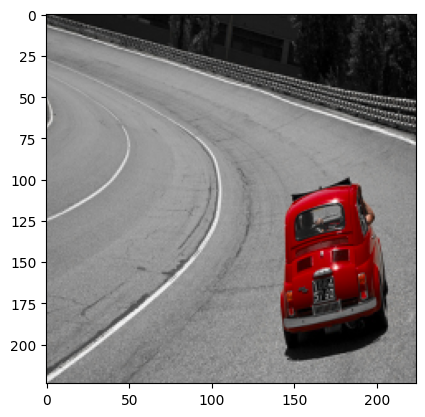

In [27]:
for x in range(1):
  img_ab = ab_test[x]
  img_l = l_test[x] * 100

  print(img_ab.shape)
  print(img_l.shape)


  img = LAB_to_RGB(img_l, img_ab)
  plt.imshow(torch.permute(img, [1,2,0]))
  plt.show()

In [28]:
dataset_ab_test = ab_test
dataset_l_test = torch.cat([l_test.unsqueeze(0)] * 3, dim=0)
dataset_l_test = torch.permute(dataset_l_test, [1,0,2,3])

print(dataset_ab_test.shape)
print(dataset_l_test.shape)

del ab_test
del l_test

torch.Size([100, 2, 224, 224])
torch.Size([100, 3, 224, 224])


### Store new dataset in the new form

In [29]:
length = 100

output_tensor = torch.zeros(length, 1, 224, 224)

for image_number in range(length):
  if image_number % 100 == 0:
    print("Image_nUmber : ", image_number)
  Z_image = np.zeros([1, 224, 224])
  image = dataset_ab_test[image_number, :, :, :]

  channel_a = torch.Tensor.int((image[0, : , :] + 110) // 10)
  channel_b = torch.Tensor.int((image[1, : , :] + 110) // 10)

  entries = [dictionary[index] for index in zip(torch.reshape(channel_a, [-1]).tolist(), torch.reshape(channel_b, [-1]).tolist())]
  entries = torch.reshape(torch.Tensor(entries), [1, 224, 224])

  output_tensor[image_number, :, :, :] = torch.tensor(entries)

Image_nUmber :  0


<ipython-input-29-9050719718fe>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output_tensor[image_number, :, :, :] = torch.tensor(entries)


In [30]:
dataset_l_test  = torch.cat([torch.unsqueeze(tens, 0) for tens in dataset_l_test])
dataset_Z_test = torch.Tensor.int(output_tensor)

print(dataset_l_test.shape)
print(dataset_Z_test.shape)


#Set up new dataset
final_test = data_utils.TensorDataset(dataset_l_test, dataset_Z_test)

torch.Size([100, 3, 224, 224])
torch.Size([100, 1, 224, 224])


In [31]:
pickle.dump(final_test, open("DF_TEST.pkl", "wb"))

In [32]:
!cp DF_TEST.pkl /content/gdrive/MyDrive/Vision/Progetto/PROGETTO_FINALE

### Load new dataset

In [33]:
objects_test = []
with (open("/content/gdrive/MyDrive/Vision/Progetto/PROGETTO_FINALE/DF_TEST.pkl", "rb")) as openfile:
    while True:
        try:
            objects_test.append(pickle.load(openfile))
        except EOFError:
            break


In [34]:
final_test = objects_test[0]

In [35]:
print(type(final_test[0]))

<class 'tuple'>


## Import network with MSE loss

### Architecture


In [36]:
class network_model_L2(nn.Module):
  def __init__(self):
    super(network_model_L2, self).__init__()

    resnet = models.resnet18(weights = "IMAGENET1K_V1")
    self.resnet_base = nn.Sequential(*list(resnet.children())[0:6]) #first 6 layers of resnet, which end with 128 channels

    for param in self.resnet_base.parameters():
      param.requires_grad = False

    # define our layers on top of resnet
    self.cnn_next = nn.Sequential(
      nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.Upsample(scale_factor=2),
      nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Upsample(scale_factor=2),
      nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(32),
      nn.ReLU(),
      nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(32),
      nn.ReLU(),
      nn.Conv2d(32, 2, kernel_size=3, stride=1, padding=1),
      nn.Upsample(scale_factor=2)
    )


  def forward(self, input):
    y = self.resnet_base(input) #first go through resnet
    z = self.cnn_next(y)        #then go through our layers
    return z

### Import weights

In [37]:
network_L2 = network_model_L2()
data = torch.load('/content/gdrive/MyDrive/Vision/Progetto/PROGETTO_FINALE/L2_model_trained_horizontalflip_larger.pt', map_location=torch.device('cpu'))

network_L2.load_state_dict(data['model_state_dict'])

network_L2.eval()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 65.0MB/s]


network_model_L2(
  (resnet_base): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

## Import network with new loss

In [38]:
network_new_loss = network_model_newLoss()
data = torch.load('/content/gdrive/MyDrive/Vision/Progetto/PROGETTO_FINALE/model_trained_horizontalflip_newloss.pt', map_location=torch.device('cpu'))

network_new_loss.load_state_dict(data['model_state_dict'])

network_new_loss.eval()

network_model_newLoss(
  (resnet_base): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_r

## Display output on test set

### Distance in (a, b) space

In [39]:
a_dict = [index[0] for index in dictionary.keys()]
b_dict = [index[1] for index in dictionary.keys()]

def distance(x, y):
  return (x[0]-y[0])**2 + (x[1] - y[1])**2

def output_to_ab_annealed(output, T = .38):
  # To go back from output to ab:

  ab = torch.zeros(2, 224, 224)
  ab_indeces = torch.zeros(2, 224, 224)

  # take output, convert dimension zero to exp(log(z)/T)
  eps = 1e-7                                              # to avoid nan in logarithm
  output_new = output
  output_new = torch.exp(torch.log(output_new + eps) / T)
  output_new = output_new / output_new.sum(dim = 0)

  # find corresponding (i,j) using inverse dictionary
  a_entries = np.zeros([224, 224])
  b_entries = np.zeros([224, 224])

  # multiply output_new by a_dict and sum
  output_a = output_new * torch.reshape(torch.tensor(a_dict), [Q, 1, 1])
  output_b = output_new * torch.reshape(torch.tensor(b_dict), [Q, 1, 1])

  # sum along axis
  output_a = torch.sum(output_a, dim = 0)
  output_b = torch.sum(output_b, dim = 0)

  output_a = (output_a + .5)*10 - 110
  output_b = (output_b + .5)*10 - 110

  ab[0, : , : ] = torch.tensor(output_a)
  ab[1, : , : ] = torch.tensor(output_b)

  return ab

### Print output images

In [40]:
for r in range(len(final_test)):

  # inputs
  input_L = final_test[r][0]
  labels =  final_test[r][1]

  v = torch.tensor(w[labels])

  zeros = torch.zeros(Q, 224, 224, dtype = torch.float64)
  one_hot = zeros.scatter(dim = 0, index = labels.type(torch.int64), src = v)

  # original
  ab_truth = output_to_ab_annealed(one_hot)
  input_RGB = LAB_to_RGB(input_L[0, :, :]*100, ab_truth)
  input_RGB.shape
  input_cpu = input_RGB.cpu()
  input_img = np.transpose(input_cpu, (1, 2, 0)).numpy()

  # reconstructed MSE
  output_L2 = network_L2(torch.unsqueeze(input_L, 0))
  output_L2_RGB = LAB_to_RGB(input_L[0, :, :]*100, output_L2[0].cpu())
  output_L2_cpu = output_L2_RGB.cpu()
  output_L2_img = np.transpose(output_L2_cpu.detach().numpy(), (1, 2, 0))

  # reconstrcted new loss
  output = network_new_loss(torch.unsqueeze(input_L, 0))
  output = torch.squeeze(output, 0)
  output_ab = output_to_ab_annealed(output)

  output_RGB = LAB_to_RGB(input_L[0, :, :]*100, output_ab)
  output_cpu = output_RGB.cpu()
  output_img = np.transpose(output_cpu, (1, 2, 0)).numpy()

  fig, axes = plt.subplots(1, 4, figsize=(12, 4))

  axes[0].imshow(input_L[0], cmap='gray')
  axes[0].axis('off')  # Turn off axis
  axes[0].set_title('Gray scale')

  axes[1].imshow(output_L2_img)
  axes[1].axis('off')  # Turn off axis
  axes[1].set_title('Colored with MSE')

  axes[2].imshow(output_img)
  axes[2].axis('off')  # Turn off axis
  axes[2].set_title('Colored with weighted loss')

  axes[3].imshow(input_img)
  axes[3].axis('off')  # Turn off axis
  axes[3].set_title('Original')

  plt.show()

  print('\n', '\n', '\n')

Output hidden; open in https://colab.research.google.com to view.